In [1]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

import numpy as np
import jax
import aeon
import torch
import torch.nn as nn
import torch.functional as F

from utils.utils import print_name, print_shape

np.set_printoptions(precision=3, threshold=5) # Print options

# Create my own here

In [2]:
import plotly.graph_objects as go
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV

# Generate noisy data with 2 features
X, y = make_regression(n_samples=300, n_features=100, noise=0.2)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a 3D scatter plot for the train set
fig_train = go.Figure(data=go.Scatter3d(
    x=X_train[:, 0],
    y=X_train[:, 1],
    z=y_train,
    mode='markers',
    marker=dict(
        size=5,
        color=y_train,
        colorscale='Viridis',
        opacity=0.8
    )
))

# Set axis labels and title for the train set plot
fig_train.update_layout(
    scene=dict(
        xaxis_title='Feature 1',
        yaxis_title='Feature 2',
        zaxis_title='y',
    ),
    title='Train Data'
)

# Create a 3D scatter plot for the test set
fig_test = go.Figure(data=go.Scatter3d(
    x=X_test[:, 0],
    y=X_test[:, 1],
    z=y_test,
    mode='markers',
    marker=dict(
        size=5,
        color=y_test,
        colorscale='Viridis',
        opacity=0.8
    )
))

# Set axis labels and title for the test set plot
fig_test.update_layout(
    scene=dict(
        xaxis_title='Feature 1',
        yaxis_title='Feature 2',
        zaxis_title='y',
    ),
    title='Test Data'
)

# Show the train and test plots
fig_train.show()
fig_test.show()


In [3]:
# Try out ridgeCV
from sklearn.linear_model import RidgeCV
alphas = np.logspace(-5, 3, 10)

model = RidgeCV(alphas = alphas)
model.fit(X_train, y_train)
y_pred_sk = model.predict(X_test)
error_sk = np.mean((y_pred_sk - y_test) ** 2)
print(model.alpha_, "model.alpha_")
print(model.coef_, "model.coef_")
print(model.intercept_, "model.intercept_")
print(y_pred_sk, "y_pred")
print(error_sk, "error")

7.742636826811278e-05 model.alpha_
[ 0.007 -0.023  0.006 ... -0.014 -0.017 -0.008] model.coef_
0.03610420328105235 model.intercept_
[405.297 285.357  84.477 ... -21.45  122.34  172.12 ] y_pred
0.06762810706218819 error


In [4]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable

import torch
from torch import Tensor

def _ridge_LOOCV_d_leq_n_HAT(
        X: Tensor,
        y: Tensor,
        alphas: List[float]
    ) -> Tuple[Tensor, float]:
    """
    LOOCV for Ridge regression when D <= N using eigendecomposition.
    """
    # Convert alphas to tensor on the same device as X
    alphas_tensor = torch.tensor(alphas, device=X.device).unsqueeze(1)  # Shape (n_alphas, 1)

    # Compute the Gram matrix
    G = X.T @ X  # Shape (D, D)

    # Perform eigendecomposition of the Gram matrix
    eigvals, eigvecs = torch.linalg.eigh(G)  # eigvals: (D,), eigvecs: (D, D)

    # Project y onto the eigenspace
    XTy = X.T @ y  # Shape (D,)
    eigvecs_T_XTy = eigvecs.T @ XTy  # Shape (D,)

    # Prepare for broadcasting
    eigvals_exp = eigvals.unsqueeze(0)  # Shape (1, D)
    eigvecs_T_XTy_exp = eigvecs_T_XTy.unsqueeze(0)  # Shape (1, D)

    # Compute denominators for all alphas
    denom = eigvals_exp + alphas_tensor  # Shape (n_alphas, D)

    # Compute alpha-scaled solutions
    beta_ridge = eigvecs @ (eigvecs_T_XTy_exp / denom).T  # Shape (D, n_alphas)

    # Compute predictions and residuals
    y_pred = X @ beta_ridge  # Shape (N, n_alphas)
    residuals = y.unsqueeze(1) - y_pred  # Shape (N, n_alphas)

    # Compute hat matrix diagonals
    # H = X @ (X^T X + alpha*I)^{-1} @ X^T
    # But we can compute the diagonal efficiently using eigendecomposition
    U = X @ eigvecs  # Shape (N, D)
    U_squared = U ** 2  # Shape (N, D)
    H_diag = (U_squared @ (1 / denom).T)  # Shape (N, n_alphas)

    # Compute LOOCV errors
    errors = ((residuals / (1 - H_diag)) ** 2).mean(dim=0)  # Shape (n_alphas,)

    # Find the best alpha
    best_idx = errors.argmin()
    best_alpha = alphas[best_idx]
    beta_optimal = beta_ridge[:, best_idx]  # Shape (D,)

    return beta_optimal, best_alpha


def _ridge_LOOCV_d_leq_n_PARALLEL(
        X: Tensor,
        y: Tensor,
        alphas: List[float]
    ) -> Tuple[Tensor, float]:
    # Convert alphas to tensor on the same device as X
    alphas_tensor = torch.tensor(alphas, device=X.device).unsqueeze(1)  # Shape (n_alphas, 1)

    # Perform SVD decomposition
    U, S, Vt = torch.linalg.svd(X, full_matrices=False)  # U: (N, D), S: (D,), Vt: (D, D)
    Ut_y = U.T @ y  # Shape (D,)

    U_squared = U ** 2  # Shape (N, D)
    S_squared = S ** 2  # Shape (D,)

    # Prepare for broadcasting
    S_exp = S.unsqueeze(0)  # Shape (1, D)
    S_squared_exp = S_squared.unsqueeze(0)  # Shape (1, D)
    Ut_y_exp = Ut_y.unsqueeze(0)  # Shape (1, D)

    # Compute denominators and d for all alphas
    denom = S_squared_exp + alphas_tensor  # Shape (n_alphas, D)
    d = S_exp / denom  # Shape (n_alphas, D)

    # Compute beta_ridge for all alphas
    d_Ut_y = d * Ut_y_exp  # Shape (n_alphas, D)
    beta_ridge = d_Ut_y @ Vt  # Shape (n_alphas, D)

    # Compute predictions and residuals
    y_pred = X @ beta_ridge.T  # Shape (N, n_alphas)
    residuals = y.unsqueeze(1) - y_pred  # Shape (N, n_alphas)

    # Compute hat matrix diagonals
    numerators = S_squared_exp / denom  # Shape (n_alphas, D)
    H_diag = (U_squared.unsqueeze(0) * numerators.unsqueeze(1)).sum(dim=2).T  # Shape (N, n_alphas)

    # Compute LOOCV errors
    errors = ((residuals / (1 - H_diag)) ** 2).mean(dim=0)  # Shape (n_alphas,)

    # Find the best alpha
    best_idx = errors.argmin()
    best_alpha = alphas[best_idx]

    # Compute optimal beta and intercept
    denom_opt = S_squared + best_alpha  # Shape (D,)
    d_optimal = S / denom_opt  # Shape (D,)
    beta_optimal = Vt.T @ (d_optimal * Ut_y)  # Shape (D,)

    return beta_optimal, best_alpha



def _ridge_LOOCV_d_leq_n(
        X: Tensor,
        y: Tensor,
        alphas: List[float]
    ) -> Tuple[Tensor, float]:
    """LOOCV for Ridge regression when D <= N.

    Args:
        X (Tensor): Shape (N, D).
        y (Tensor): Shape (N, p).
        alphas (List[float]): Alphas to test.
    
    Returns:
        Tuple[Tensor, float]: Coefficients beta and intercept.
    """
    # Use SVD for decomposition
    U, S, Vt = torch.linalg.svd(X, full_matrices=False)
    Ut_y = U.T @ y
    U_squared = U ** 2

    # Efficient LOOCV
    best_alpha = -1
    best_error = torch.inf
    for alpha in alphas:
        d = S / (S**2 + alpha)
        beta_ridge = Vt.T @ (d * Ut_y)
        y_pred = X @ beta_ridge
        residuals = y - y_pred
        H_diag = torch.sum(U_squared * (S**2 / (S**2 + alpha)), dim=1)
        error = ((residuals / (1 - H_diag)) ** 2).mean()

        if error < best_error:
            best_error = error
            best_alpha = alpha

    # Compute optimal beta and intercept
    d_optimal = S / (S**2 + best_alpha)
    optimal_beta = Vt.T @ (d_optimal * Ut_y)
    return optimal_beta, best_alpha



def _ridge_LOOCV_n_leq_d(
        X: Tensor,
        y: Tensor,
        alphas: List[float]
    ) -> Tuple[Tensor, float]:
    """LOOCV for Ridge regression when N < D.

    Args:
        X (Tensor): Shape (N, D).
        y (Tensor): Shape (N,).
        alphas (List[float]): Alphas to test.
    
    Returns:
        Tuple[Tensor, float]: Coefficients beta and intercept.
    """
    # Use eigendecomposition of Gram matrix
    K = X @ X.T
    eigvals, Q = torch.linalg.eigh(K)
    QT_y = Q.T @ y

    # Efficient LOOCV
    best_alpha = -1
    best_error = torch.inf
    for alpha in alphas:
        w = 1.0 / (eigvals + alpha)
        c = Q @ (w * QT_y)
        y_pred = K @ c
        residuals = y - y_pred
        H_diag = torch.sum( (Q ** 2) * (eigvals / (eigvals + alpha)), dim=1)
        error = ((residuals / (1 - H_diag)) ** 2).mean()

        if error < best_error:
            best_error = error
            best_alpha = alpha

    # Compute optimal beta and intercept
    w_opt = 1.0 / (eigvals + best_alpha)
    c_opt = Q @ (w_opt * QT_y)
    optimal_beta = X.T @ c_opt
    return optimal_beta, best_alpha



def fit_ridge_LOOCV(
        X: Tensor, 
        y: Tensor, 
        alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    ) -> Tuple[Tensor, float]:
    """Find the optimal Ridge fit using efficient Leave-One-Out 
    Cross-Validation with SVD and eigendecomposition.

    Args:
        X (Tensor): Input data of shape (N, D).
        y (Tensor): Target data of shape (N,).
        alphas (List): List of alphas to test.
    
    Returns:
        Tuple[Tensor, float]: Coefficients beta and intercept.
    """
    # Compute means
    X_mean = X.mean(dim=0)
    y_mean = y.mean(dim=0)

    # Center X and y
    X_centered = X - X_mean
    y_centered = y - y_mean

    N, D = X.shape
    if N >= D:
        #beta_optimal, best_alpha = _ridge_LOOCV_d_leq_n(X_centered, y_centered, alphas)
        beta_optimal, best_alpha = _ridge_LOOCV_d_leq_n_PARALLEL(X_centered, y_centered, alphas)
    else:
        beta_optimal, best_alpha = _ridge_LOOCV_n_leq_d(X_centered, y_centered, alphas)

    # Adjust intercept
    intercept = y_mean - X_mean @ beta_optimal

    return beta_optimal, intercept, best_alpha

In [5]:
device = "cpu"
X  = torch.tensor(X_train).to(device)
y = torch.tensor(y_train).to(device)
t_X_test = torch.tensor(X_test).to(device)
t_y_test = torch.tensor(y_test).to(device)

beta, intercept, alpha = fit_ridge_LOOCV(X, y, alphas=alphas)
y_pred = t_X_test @ beta + intercept
error = ((t_y_test - y_pred) ** 2).mean().item()
print(alpha, "alpha")
print(beta, "beta")
print(intercept, "intercept")
print(y_pred, "y_pred")
print(error, "error")

7.742636826811278e-05 alpha
tensor([ 6.8566e-03, -2.3148e-02,  6.1992e-03,  1.3716e-02,  7.0542e+01,
         1.5222e-02, -3.8938e-02, -2.3546e-02,  2.7632e+01,  1.1695e-02,
         3.4039e-02,  6.7309e-04,  7.1034e-03,  3.4713e-03, -1.5038e-02,
         1.6882e-02,  1.9304e-02,  4.8377e+01, -2.4744e-02, -1.6282e-02,
        -1.1041e-02, -1.7839e-02,  6.2789e-03, -6.2007e-03,  5.6112e-03,
         1.2618e-02, -1.2611e-02,  1.0705e-03,  3.2069e-02,  4.8554e-04,
        -1.6501e-02,  9.8008e-03, -6.9290e-03, -7.1571e-03, -1.8995e-02,
         2.1613e-02, -2.8451e-02, -1.2152e-02,  2.1563e-03, -1.8207e-02,
        -3.4229e-02, -8.3649e-03,  9.5121e+01, -1.6566e-02,  1.9997e-02,
         1.3842e-02,  8.0048e-04,  1.4528e-02,  4.6088e+00,  3.6559e-02,
         4.4600e+01,  1.2651e-02,  9.3314e+01,  1.1371e-02,  1.5106e-02,
         2.7292e-03, -2.7736e-02, -7.2366e-03,  4.6317e-03,  2.5916e-02,
        -8.1033e-03,  6.2566e-03, -8.3099e-03,  1.3473e-02,  1.1676e-02,
        -3.1554e-02, -7

In [6]:
# compare sklearn and torch
print("sklearn")
print(model.alpha_, "model.alpha_")
print(model.coef_, "model.coef_")
print(model.intercept_, "model.intercept_")
print(y_pred_sk, "y_pred")
print(error_sk, "error")


sklearn
7.742636826811278e-05 model.alpha_
[ 0.007 -0.023  0.006 ... -0.014 -0.017 -0.008] model.coef_
0.03610420328105235 model.intercept_
[405.297 285.357  84.477 ... -21.45  122.34  172.12 ] y_pred
0.06762810706218819 error


In [7]:

# torch
print(alpha, "alpha")
print(beta, "beta")
print(intercept, "intercept")
print(y_pred, "y_pred")
print(error, "error")


7.742636826811278e-05 alpha
tensor([ 6.8566e-03, -2.3148e-02,  6.1992e-03,  1.3716e-02,  7.0542e+01,
         1.5222e-02, -3.8938e-02, -2.3546e-02,  2.7632e+01,  1.1695e-02,
         3.4039e-02,  6.7309e-04,  7.1034e-03,  3.4713e-03, -1.5038e-02,
         1.6882e-02,  1.9304e-02,  4.8377e+01, -2.4744e-02, -1.6282e-02,
        -1.1041e-02, -1.7839e-02,  6.2789e-03, -6.2007e-03,  5.6112e-03,
         1.2618e-02, -1.2611e-02,  1.0705e-03,  3.2069e-02,  4.8554e-04,
        -1.6501e-02,  9.8008e-03, -6.9290e-03, -7.1571e-03, -1.8995e-02,
         2.1613e-02, -2.8451e-02, -1.2152e-02,  2.1563e-03, -1.8207e-02,
        -3.4229e-02, -8.3649e-03,  9.5121e+01, -1.6566e-02,  1.9997e-02,
         1.3842e-02,  8.0048e-04,  1.4528e-02,  4.6088e+00,  3.6559e-02,
         4.4600e+01,  1.2651e-02,  9.3314e+01,  1.1371e-02,  1.5106e-02,
         2.7292e-03, -2.7736e-02, -7.2366e-03,  4.6317e-03,  2.5916e-02,
        -8.1033e-03,  6.2566e-03, -8.3099e-03,  1.3473e-02,  1.1676e-02,
        -3.1554e-02, -7

In [8]:

# differences
print("differences")
print(model.alpha_ - alpha, "alpha")
print(model.coef_ - beta.numpy(), "beta")
print(model.intercept_ - intercept.numpy(), "intercept")
print(y_pred_sk - y_pred.numpy(), "y_pred")
print(error_sk - error, "error")



differences
0.0 alpha
[-1.373e-07  1.162e-07 -2.616e-07 ... -1.949e-08  6.566e-08 -4.084e-08] beta
-3.100376488873735e-08 intercept
[-5.225e-07  2.953e-06  3.511e-07 ...  3.813e-06  1.563e-06  1.979e-06] y_pred
4.785329636713964e-08 error


In [11]:
import torch
import numpy as np
import time
from sklearn.linear_model import RidgeCV
# Define your alphas
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

# List of N values to test
Ns = [100, 1000, 10000, 100000]
D = 5

# Initialize a dictionary to store execution times
execution_times = {}

# Loop over different N values
with torch.no_grad():
    for N in Ns:
        print(f"\nTesting with N = {N}, D = {D}")
        # Check if CUDA is available
        devices = ['cpu']
        if torch.cuda.is_available():
            devices.append('cuda')

        for device in devices:
            print(f"\nRunning on device: {device}")
            # Generate random data
            X = torch.randn(N, D, device=device)
            X = X - X.mean(dim=0)
            y = torch.randn(N, device=device)
            y = y - y.mean()

            # Initialize dictionary for the device if not already
            if device not in execution_times:
                execution_times[device] = {
                    'N_values': [],
                    '_ridge_LOOCV_d_leq_n': [],
                    '_ridge_LOOCV_d_leq_n_PARALLEL': [],
                    '_ridge_LOOCV_d_leq_n_HAT': []
                }
                if device == 'cpu':
                    execution_times[device]['RidgeCV'] = []

            execution_times[device]['N_values'].append(N)

            # Time _ridge_LOOCV_d_leq_n
            start_time = time.time()
            beta_opt, best_alpha = _ridge_LOOCV_d_leq_n(X, y, alphas)
            if device == 'cuda':
                torch.cuda.synchronize()
            time_ridge_LOOCV = time.time() - start_time
            execution_times[device]['_ridge_LOOCV_d_leq_n'].append(time_ridge_LOOCV)
            print(f"_ridge_LOOCV_d_leq_n time: {time_ridge_LOOCV:.4f} seconds")

            # Time _ridge_LOOCV_d_leq_n_PARALLEL
            start_time = time.time()
            beta_opt_par, best_alpha_par = _ridge_LOOCV_d_leq_n_PARALLEL(X, y, alphas)
            if device == 'cuda':
                torch.cuda.synchronize()
            time_ridge_LOOCV_PARALLEL = time.time() - start_time
            execution_times[device]['_ridge_LOOCV_d_leq_n_PARALLEL'].append(time_ridge_LOOCV_PARALLEL)
            print(f"_ridge_LOOCV_d_leq_n_PARALLEL time: {time_ridge_LOOCV_PARALLEL:.4f} seconds")

            # Time _ridge_LOOCV_d_leq_n_HAT
            start_time = time.time()
            beta_opt_hat, best_alpha_hat = _ridge_LOOCV_d_leq_n_HAT(X, y, alphas)
            if device == 'cuda':
                torch.cuda.synchronize()
            time_ridge_LOOCV_HAT = time.time() - start_time
            execution_times[device]['_ridge_LOOCV_d_leq_n_HAT'].append(time_ridge_LOOCV_HAT)
            print(f"_ridge_LOOCV_d_leq_n_HAT time: {time_ridge_LOOCV_HAT:.4f} seconds")

            # Time RidgeCV from scikit-learn (CPU only)
            if device == 'cpu':
                X_np = X.cpu().numpy()
                y_np = y.cpu().numpy()
                start_time = time.time()
                model = RidgeCV(alphas=alphas)
                model.fit(X_np, y_np)
                time_RidgeCV = time.time() - start_time
                execution_times[device]['RidgeCV'].append(time_RidgeCV)
                print(f"RidgeCV time: {time_RidgeCV:.4f} seconds")

import matplotlib.pyplot as plt
# Plot the results
# Define your alphas
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

# List of N values to test
Ns = [100, 1000, 10000, 100000]
D = 500

# Initialize a dictionary to store execution times
execution_times = {}

# Loop over different N valuesfor N in Ns:
for N in Ns:
    print(f"\nTesting with N = {N}, D = {D}")
    # Check if CUDA is available
    devices = ['cpu']
    if torch.cuda.is_available():
        devices.append('cuda')

    for device in devices:
        print(f"\nRunning on device: {device}")
        # Generate random data
        X = torch.randn(N, D, device=device)
        X = X - X.mean(dim=0)
        y = torch.randn(N, device=device)
        y = y - y.mean()

        # Initialize dictionary for the device if not already
        if device not in execution_times:
            execution_times[device] = {
                'N_values': [],
                '_ridge_LOOCV_d_leq_n': [],
                '_ridge_LOOCV_d_leq_n_PARALLEL': [],
                '_ridge_LOOCV_d_leq_n_HAT': []
            }
            if device == 'cpu':
                execution_times[device]['RidgeCV'] = []

        execution_times[device]['N_values'].append(N)

        # Time _ridge_LOOCV_d_leq_n
        start_time = time.time()
        beta_opt, best_alpha = _ridge_LOOCV_d_leq_n(X, y, alphas)
        if device == 'cuda':
            torch.cuda.synchronize()
        time_ridge_LOOCV = time.time() - start_time
        execution_times[device]['_ridge_LOOCV_d_leq_n'].append(time_ridge_LOOCV)
        print(f"_ridge_LOOCV_d_leq_n time: {time_ridge_LOOCV:.4f} seconds")

        # Time _ridge_LOOCV_d_leq_n_PARALLEL
        start_time = time.time()
        beta_opt_par, best_alpha_par = _ridge_LOOCV_d_leq_n_PARALLEL(X, y, alphas)
        if device == 'cuda':
            torch.cuda.synchronize()
        time_ridge_LOOCV_PARALLEL = time.time() - start_time
        execution_times[device]['_ridge_LOOCV_d_leq_n_PARALLEL'].append(time_ridge_LOOCV_PARALLEL)
        print(f"_ridge_LOOCV_d_leq_n_PARALLEL time: {time_ridge_LOOCV_PARALLEL:.4f} seconds")

        # Time _ridge_LOOCV_d_leq_n_HAT
        start_time = time.time()
        beta_opt_hat, best_alpha_hat = _ridge_LOOCV_d_leq_n_HAT(X, y, alphas)
        if device == 'cuda':
            torch.cuda.synchronize()
        time_ridge_LOOCV_HAT = time.time() - start_time
        execution_times[device]['_ridge_LOOCV_d_leq_n_HAT'].append(time_ridge_LOOCV_HAT)
        print(f"_ridge_LOOCV_d_leq_n_HAT time: {time_ridge_LOOCV_HAT:.4f} seconds")

        # Time RidgeCV from scikit-learn (CPU only)
        if device == 'cpu':
            X_np = X.cpu().numpy()
            y_np = y.cpu().numpy()
            start_time = time.time()
            model = RidgeCV(alphas=alphas)
            model.fit(X_np, y_np)
            time_RidgeCV = time.time() - start_time
            execution_times[device]['RidgeCV'].append(time_RidgeCV)
            print(f"RidgeCV time: {time_RidgeCV:.4f} seconds")



Testing with N = 100, D = 5

Running on device: cpu
_ridge_LOOCV_d_leq_n time: 0.0015 seconds
_ridge_LOOCV_d_leq_n_PARALLEL time: 0.0005 seconds
_ridge_LOOCV_d_leq_n_HAT time: 0.0005 seconds
RidgeCV time: 0.0019 seconds

Running on device: cuda
_ridge_LOOCV_d_leq_n time: 0.0056 seconds
_ridge_LOOCV_d_leq_n_PARALLEL time: 0.0012 seconds
_ridge_LOOCV_d_leq_n_HAT time: 0.0011 seconds

Testing with N = 1000, D = 5

Running on device: cpu
_ridge_LOOCV_d_leq_n time: 0.0012 seconds
_ridge_LOOCV_d_leq_n_PARALLEL time: 0.0004 seconds
_ridge_LOOCV_d_leq_n_HAT time: 0.0003 seconds
RidgeCV time: 0.0017 seconds

Running on device: cuda
_ridge_LOOCV_d_leq_n time: 0.0039 seconds
_ridge_LOOCV_d_leq_n_PARALLEL time: 0.0017 seconds
_ridge_LOOCV_d_leq_n_HAT time: 0.0008 seconds

Testing with N = 10000, D = 5

Running on device: cpu
_ridge_LOOCV_d_leq_n time: 0.0017 seconds
_ridge_LOOCV_d_leq_n_PARALLEL time: 0.0010 seconds
_ridge_LOOCV_d_leq_n_HAT time: 0.0005 seconds
RidgeCV time: 0.0145 seconds

Runni


Execution times data:
Device: cpu
  N_values: [100, 1000, 10000, 100000]
  _ridge_LOOCV_d_leq_n: [0.0453951358795166, 0.05684399604797363, 0.2669804096221924, 3.0450570583343506]
  _ridge_LOOCV_d_leq_n_PARALLEL: [0.006620883941650391, 0.049127817153930664, 0.25113463401794434, 3.0674238204956055]
  _ridge_LOOCV_d_leq_n_HAT: [0.01068258285522461, 0.01863861083984375, 0.05640435218811035, 0.6972031593322754]
  RidgeCV: [0.04452013969421387, 0.16114282608032227, 1.3327696323394775, 13.873950004577637]
Device: cuda
  N_values: [100, 1000, 10000, 100000]
  _ridge_LOOCV_d_leq_n: [0.025273799896240234, 0.06610512733459473, 0.06374764442443848, 0.3136899471282959]
  _ridge_LOOCV_d_leq_n_PARALLEL: [0.006215810775756836, 0.04245734214782715, 0.0576634407043457, 0.30837512016296387]
  _ridge_LOOCV_d_leq_n_HAT: [0.057448625564575195, 0.023966550827026367, 0.022272825241088867, 0.04479813575744629]


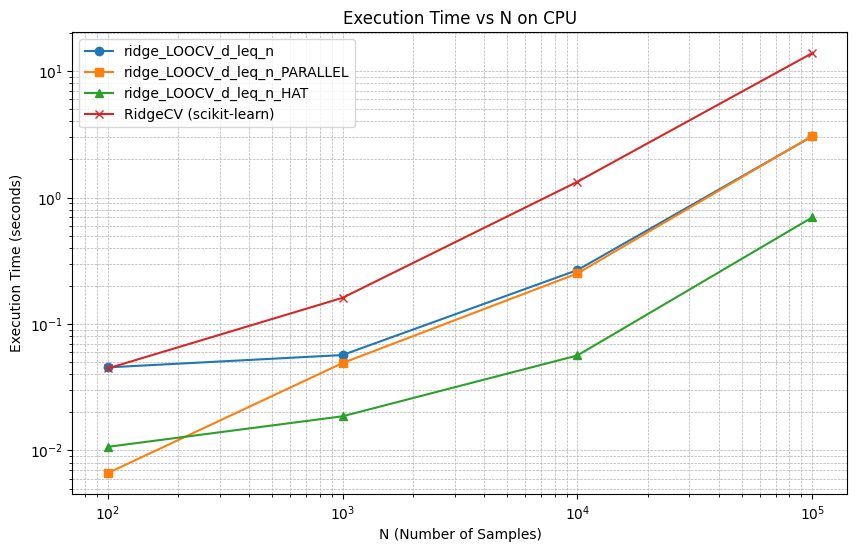

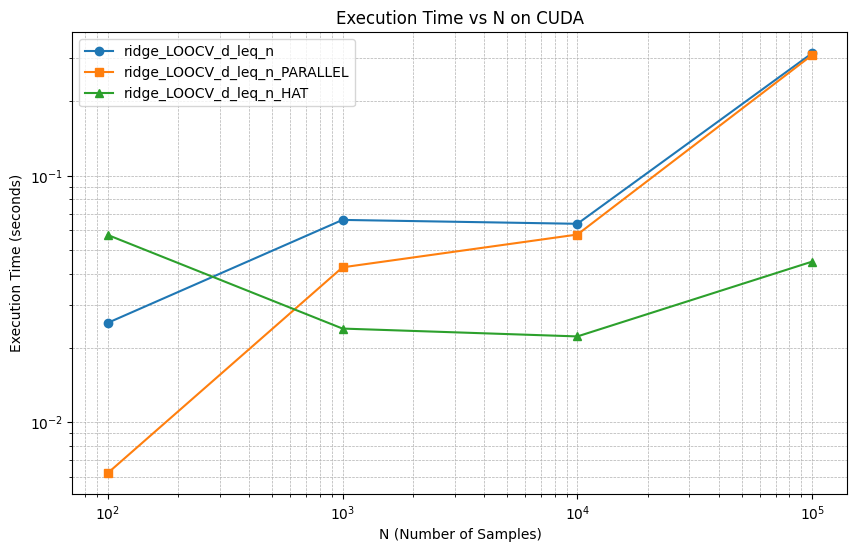

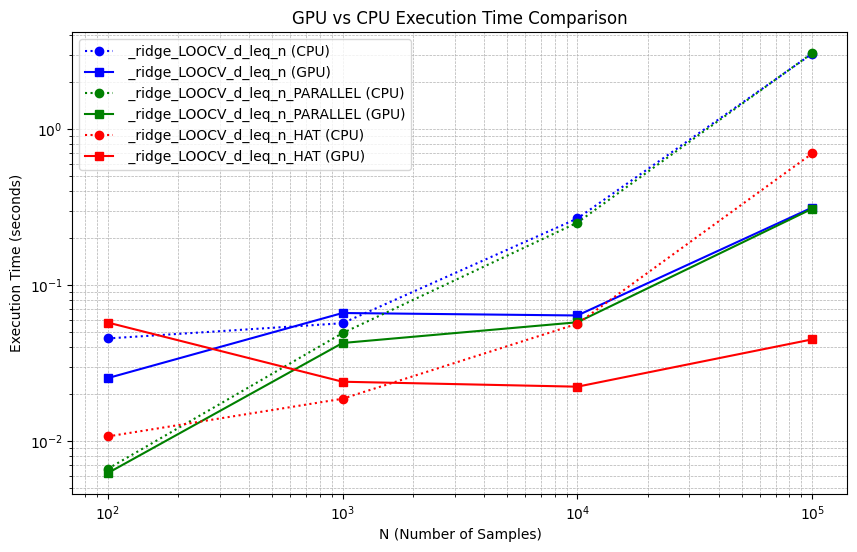

In [18]:

# Debug print to check the contents of execution_times
print("\nExecution times data:")
for device, times in execution_times.items():
    print(f"Device: {device}")
    for key, value in times.items():
        print(f"  {key}: {value}")

# Plot the results
for device in execution_times.keys():
    plt.figure(figsize=(10, 6))
    N_values = execution_times[device]['N_values']
    plt.plot(N_values, execution_times[device]['_ridge_LOOCV_d_leq_n'], marker='o', label='ridge_LOOCV_d_leq_n')
    plt.plot(N_values, execution_times[device]['_ridge_LOOCV_d_leq_n_PARALLEL'], marker='s', label='ridge_LOOCV_d_leq_n_PARALLEL')
    plt.plot(N_values, execution_times[device]['_ridge_LOOCV_d_leq_n_HAT'], marker='^', label='ridge_LOOCV_d_leq_n_HAT')
    if device == 'cpu':
        plt.plot(N_values, execution_times[device]['RidgeCV'], marker='x', label='RidgeCV (scikit-learn)')

    plt.xlabel('N (Number of Samples)')
    plt.ylabel('Execution Time (seconds)')
    plt.title(f'Execution Time vs N on {device.upper()}')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.show()

# Plot GPU vs CPU processing times with same color but different line styles
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r']  # Define a list of colors for different methods
for idx, method in enumerate(['_ridge_LOOCV_d_leq_n', '_ridge_LOOCV_d_leq_n_PARALLEL', '_ridge_LOOCV_d_leq_n_HAT']):
    plt.plot(execution_times['cpu']['N_values'], execution_times['cpu'][method], marker='o', linestyle='dotted', color=colors[idx], label=f' {method} (CPU)')
    plt.plot(execution_times['cuda']['N_values'], execution_times['cuda'][method], marker='s', linestyle='solid', color=colors[idx], label=f' {method} (GPU)')

plt.xlabel('N (Number of Samples)')
plt.ylabel('Execution Time (seconds)')
plt.title('GPU vs CPU Execution Time Comparison')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()